# Demo
- How to use mfishtools for gene panel selection and posthoc analysis
    - This example is specific to "Learning mFISH" project
        - Currently only for neuronal cell types
        - "group" labeling can be ignored (more info in the following cells)
        - Layer selection is specific to learning mFISH project (can be ignored)
        - Data is currently only available to Allen Institute members (through isilon drive)

In [19]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from importlib import reload
import datetime
from glob import glob
import json
import os

from mfishtoolspy import gene_panel_selection, filtering, plotting



# Setting the options
- Necessary information: 
    - For input to the function: 'full_panel_size', 'starting_genes', 'max_on', 'max_off', 'min_on', 'max_fraction_on_clusters', 'num_subsamle'
    - For pre-processing the options: 'panel_name', 'GABAergic_mapping_level', 'Glutamatergic_mapping_level', 

In [8]:
# options for cluster grouping
ops = {
    # 'panel_name': 'Pan-neuronal', # GABAergic or Glutamatergic or Pan-neuronal
    'panel_name': 'GABAergic', # GABAergic or Glutamatergic or Pan-neuronal
    # 'full_panel_size': 28,
    'full_panel_size': 22,
    # 'starting_genes': ["Gad2","Slc17a7","Pvalb","Sst","Vip","Cck","Tac1","Npy","Crh","Necab1","Ptprt","Kirrel3","Penk","Hpse","Calb2","Chodl"],
    'starting_genes': ["Gad2","Slc17a7","Pvalb","Sst","Vip", "Sncg", "Lamp5", "Npy", "Calb2", "Tac1", "Cck", "Ndnf"],
    'layer_1234_filter': True,
    'GABAergic_group_level': 'cluster', # class, subclass, supertype, or cluster
    'GABAergic_mapping_level': 'cluster',
    'Glutamatergic_group_level': 'subclass', # class, subclass, supertype, or cluster
    'Glutamatergic_mapping_level': 'subclass',
    'GABAergic_other_group_level': 'subclass', # class, subclass, supertype, or cluster
    'GABAergic_other_mapping_level': 'subclass',
    'Glutamatergic_other_group_level': 'class', # class, subclass, supertype, or cluster
    'Glutamatergic_other_mapping_level': 'class',
    'blend_supertypes': False,  # Don't know if I'm going to keep this
    'remove_redundant_genes': False, # from the starting_genes list
    'remove_redundant_genes_threshold': 0.95, # threshold for removing redundant genes from normalized accuracy
    'L1234_layer_threshold': 0.15,
    'L6_layer_threshold': 0.7,
    'L1234_labels': ['L1', 'L1-L2/3', 'L1-L4', 'L2/3', 'L2/3-L4', 'L4'],
    'L6_labels': ['L6', 'L6b'],
    'max_on': 5000,
    'max_off': 1129,
    'min_on': 10,
    'max_fraction_on_clusters': 0.5,
    'num_subsample': 50,
}

# paths to the data
data_folder = Path(r'\\allen\programs\mindscope\workgroups\learning\jinho\gene_panel_selection\mfishtoolspy\data'.replace('\\', '/'))
output_folder = Path(r'\\allen\programs\mindscope\workgroups\learning\jinho\gene_panel_selection\mfishtoolspy\results'.replace('\\', '/'))

In [9]:
# preprocess options
if 'GABAergic' in ops['panel_name']:
    ops['keep_class'] = ['GABAergic']
elif 'Glutamatergic' in ops['panel_name']:
    ops['keep_class'] = ['Glutamatergic']
elif 'Pan-neuronal' in ops['panel_name']:
    ops['keep_class'] = ['GABAergic', 'Glutamatergic']
else:
    raise ValueError('panel_name must be GABAergic, Glutamatergic, or Pan-neuronal')

level_hierarchy = {'class': 0, 'subclass': 1, 'supertype': 2, 'cluster': 3}
assert level_hierarchy[ops['GABAergic_group_level']] <= level_hierarchy[ops['GABAergic_mapping_level']]
assert level_hierarchy[ops['GABAergic_other_group_level']] <= level_hierarchy[ops['GABAergic_other_mapping_level']]
assert level_hierarchy[ops['Glutamatergic_group_level']] <= level_hierarchy[ops['Glutamatergic_mapping_level']]
assert level_hierarchy[ops['Glutamatergic_other_group_level']] <= level_hierarchy[ops['Glutamatergic_other_mapping_level']]


In [12]:
# load and pre-process data (takes about 1 min)
# Includes adding custom supertype annotation

# read annotation
annotation = pd.read_feather(data_folder / 'anno.feather')
annotation.set_index('sample_id', inplace=True, drop=True)

# read data
tpm_data = pd.read_feather(data_folder / 'exon_tpm.feather')

# change the row order of annotation to match the order of columns in data
# annotation = annotation.loc[data.columns]  # don't need this, but add assert statement to check
assert np.all(annotation.index.values == tpm_data.columns.values)

# data conversion to log2
tpm_log2 = np.log2(tpm_data + 1)

# read supertype information
supertype_fn = supertype_folder / 'tasic2018_supertypes_manual_v2.xlsx'
sheet_name = 'all_supertypes_v2'
supertype = pd.read_excel(supertype_fn, sheet_name=sheet_name)
supertype.rename(columns={'Cell Type': 'cell_type', 'Supertype': 'supertype'}, inplace=True)
supertype.cell_type = supertype.cell_type.str.replace('\xa0', ' ')
supertype.supertype = supertype.supertype.str.replace('\xa0', ' ')
assert np.all([ct in annotation['cluster_label'].values for ct in supertype.cell_type.values])
supertype.set_index('cell_type', inplace=True, drop=True)

annotation['supertype_label'] = annotation.cluster_label.map(supertype.supertype)

C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_7248\4148288994.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  annotation['supertype_label'] = annotation.cluster_label.map(supertype.supertype)


# Assign mappings and groups and update the ops dictionary
- Filtering and assigning group_label
- "Group" means target clustering that I want to classify eventually. 
- There is also mapping_label from annotation, to which I want to map each cell first before calculating classification accuracy.
- Group label and mapping label can be different. (When these two labels are the same, then "group" can be ignored.)
    - E.g., match individual samples to cluster level but then classify them at supertype level. When classification is done at the cluster level.
    - E.g., classification can happen in mixed level, some at the cluster level while others in subclass level
    - In both examples, one can modify mapping_label to a desired classification. The caveat is then gene expression distribution can be multimodal, and median value won't be representative.
- "Other" means cell types that the user do not want to include in the analysis, but will be included in the imaging volume.
    - "Other" is relevant only when filtering by the layers in this example.
    - For example, when one wants to classify cells corresponding to L1-L4 neurons, but expects to have some L5 neurons. Then, L5 neurons can be assigned to "other" group.


In [13]:
group_label = f'{ops["Glutamatergic_group_level"]}_label'
mapping_label = f'{ops["Glutamatergic_mapping_level"]}_label'
temp_annotation = annotation.query('class_label=="Glutamatergic"')

keep_groups = []  # group of interest
keep_mappings = [] # mapping of interest
other_groups = []  # group of non-interest
other_mappings = []  # mapping of non-interest

if 'Glutamatergic' in ops['keep_class']:
    # Assign group and mapping labels
    group_level_label = f'{ops["Glutamatergic_group_level"]}_label'
    group_label_list = [f'Glutamatergic {gl}' for gl in annotation.loc[annotation.class_label == 'Glutamatergic', group_level_label]] # To disambiguate from GABAergic groups
    annotation.loc[annotation.class_label == 'Glutamatergic', 'group_label'] = group_label_list
    mapping_level_label = f'{ops["Glutamatergic_mapping_level"]}_label'
    mapping_label_list = [f'Glutamatergic {ml}' for ml in annotation.loc[annotation.class_label == 'Glutamatergic', mapping_label]] # To disambiguate from GABAergic mappings
    annotation.loc[annotation.class_label == 'Glutamatergic', 'mapping_label'] = mapping_label_list
    
    # Assign keep and other groups.
    # If lower than class level, then consider layer filtering (L1234 only for now)
    if ops['Glutamatergic_group_level'] == 'class':
        keep_groups += ['Glutamatergic']
    else:
        temp_annotation = annotation.query('class_label=="Glutamatergic"')
        if ops['layer_1234_filter']:
            keep_groups += [gl for gl in temp_annotation['group_label'].unique().tolist() if gl.split(' ')[1] in ['L2/3', 'L4']] # Have class label at the beginning
            # Process "other" groups
            other_group_level_label = f'{ops["Glutamatergic_other_group_level"]}_label'
            temp_other_groups = [gl for gl in temp_annotation['group_label'].unique().tolist() if gl.split(' ')[1] in ['L5', 'NP']] # Have class label at the beginning
            if other_group_level_label == group_level_label: # no need to change group labels
                other_groups += temp_other_groups
            else:
                # Add L5 after class label
                other_group_labels = [f'Glutamatergic L5 {gl}' for gl in annotation[annotation['group_label'].isin(temp_other_groups)][other_group_level_label].values]
                annotation.loc[annotation['group_label'].isin(temp_other_groups), 'group_label'] = other_group_labels
                other_groups += np.unique(other_group_labels).tolist()
        else:
            keep_groups += temp_annotation['group_label'].unique().tolist()
    # Assign keep and other mappings.
    if ops['Glutamatergic_mapping_level'] == 'class':
        keep_mappings += ['Glutamatergic']
    else:
        temp_annotation = annotation.query('class_label=="Glutamatergic"')
        if ops['layer_1234_filter']:
            keep_mappings += [ml for ml in temp_annotation['mapping_label'].unique().tolist() if ml.split(' ')[1] in ['L2/3', 'L4']] # Have class label at the beginning
            # Process "other" groups
            other_mapping_level_label = f'{ops["Glutamatergic_other_mapping_level"]}_label'
            temp_other_mappings = [ml for ml in temp_annotation['mapping_label'].unique().tolist() if ml.split(' ')[1] in ['L5', 'NP']] # Have class label at the beginning
            if other_mapping_level_label == mapping_level_label: # no need to change mapping labels
                other_mappings += temp_other_mappings
            else:
                # Add L5 after class label
                other_mapping_labels = [f'Glutamatergic L5 {ml}' for ml in annotation[annotation['mapping_label'].isin(temp_other_mappings)][other_mapping_level_label].values]
                annotation.loc[annotation['mapping_label'].isin(temp_other_mappings), 'mapping_label'] = other_mapping_labels
                other_mappings += np.unique(other_mapping_labels).tolist()
        else:
            keep_mappings += temp_annotation['mapping_label'].unique().tolist()

# Same for GABAergic
# Except for filtering, now we are using scRNAseq layer-enriched data with thresholds
if 'GABAergic' in ops['keep_class']:
    # Assign group and mapping labels
    group_level_label = f'{ops["GABAergic_group_level"]}_label'
    group_label_list = [f'GABAergic {gl}' for gl in annotation.loc[annotation.class_label == 'GABAergic', group_level_label]] # To disambiguate from Glutamatergic groups
    annotation.loc[annotation.class_label == 'GABAergic', 'group_label'] = group_label_list
    mapping_level_label = f'{ops["GABAergic_mapping_level"]}_label'
    mapping_label_list = [f'GABAergic {ml}' for ml in annotation.loc[annotation.class_label == 'GABAergic', mapping_level_label]] # To disambiguate from Glutamatergic mappings
    annotation.loc[annotation.class_label == 'GABAergic', 'mapping_label'] = mapping_label_list
    
    # Assign keep and other groups.
    # If lower than class level, then consider layer filtering (L1234 only for now)
    # Also need to name them different (adding L5 in front of the group and mapping labels)
    if ops['GABAergic_group_level'] == 'class':
        keep_groups += ['GABAergic']
    else:
        temp_annotation = annotation.query('class_label=="GABAergic"')
        if ops['layer_1234_filter']:
            # Filtering process based on the layer abundance
            layer_df = annotation.query('class_label=="GABAergic"')[['layer_label', 'cluster_label']].copy()
            layer_table = layer_df.groupby(['layer_label', 'cluster_label']).size().unstack(fill_value=0)
            prop_table = layer_table.div(layer_table.sum(axis=0), axis=1)
            L1234_prop_sum = prop_table.loc[ops['L1234_labels']].sum(axis=0)
            L1234_inh_types = set(L1234_prop_sum[L1234_prop_sum >= ops['L1234_layer_threshold']].index.values)
            not_L1234_inh_types = set(layer_df.cluster_label).difference(L1234_inh_types)
            L6_prop_sum = prop_table.loc[ops['L6_labels']].sum(axis=0)
            L6_inh_types = set(L6_prop_sum[L6_prop_sum >= ops['L6_layer_threshold']].index.values)
            L5_inh_types = not_L1234_inh_types.difference(L6_inh_types)
            # L1234_inh_types are going to be kept
            # L5_inh_types are going to be "other"
            # Ignore L6_inh_types (assume they won't be imaged)
            keep_annotation = temp_annotation[temp_annotation['cluster_label'].isin(L1234_inh_types)]
            other_annotation = temp_annotation[temp_annotation['cluster_label'].isin(L5_inh_types)]
            
            keep_groups += keep_annotation['group_label'].unique().tolist()

            # Process "other" groups
            other_group_level_label = f'{ops["GABAergic_other_group_level"]}_label'
            temp_other_groups = other_annotation['group_label'].unique().tolist()
            if other_group_level_label == group_level_label: # no need to change group labels
                other_groups += temp_other_groups
            else:
                # Add L5 after class label
                other_group_labels = [f'GABAergic L5 {gl}' for gl in annotation[annotation['group_label'].isin(temp_other_groups)][other_group_level_label].values]
                annotation.loc[annotation['group_label'].isin(temp_other_groups), 'group_label'] = other_group_labels
                other_groups += np.unique(other_group_labels).tolist()
        else:
            keep_groups += temp_annotation['group_label'].unique().tolist()
    # Assign keep and other mappings.
    if ops['GABAergic_mapping_level'] == 'class':
        keep_mappings += ['GABAergic']
    else:
        temp_annotation = annotation.query('class_label=="GABAergic"')
        if ops['layer_1234_filter']:
            # Filtering process should have been done already in the above if clause
            # keep_annotation and other_annotation are already defined
            keep_mappings += keep_annotation['mapping_label'].unique().tolist()
            
            # Process "other" groups
            other_mapping_level_label = f'{ops["GABAergic_other_mapping_level"]}_label'
            temp_other_mappings = other_annotation['mapping_label'].unique().tolist()
            if other_mapping_level_label == mapping_level_label: # no need to change mapping labels
                other_mappings += temp_other_mappings
            else:
                # Add L5 after class label
                other_mapping_labels = [f'GABAergic L5 {ml}' for ml in annotation[annotation['mapping_label'].isin(temp_other_mappings)][other_mapping_level_label].values]
                annotation.loc[annotation['mapping_label'].isin(temp_other_mappings), 'mapping_label'] = other_mapping_labels
                other_mappings += np.unique(other_mapping_labels).tolist()
        else:
            keep_mappings += temp_annotation['mapping_label'].unique().tolist()

# assign cluster to nan mapping labels
# for filtering using "off clusters" information (e.g., glial cells)
annotation.loc[annotation['mapping_label']=='nan', 'mapping_label'] = annotation.loc[annotation['mapping_label']=='nan', 'cluster_label'] 


ops['keep_mappings'] = keep_mappings
ops['other_mappings'] = other_mappings
ops['keep_groups'] = keep_groups
ops['other_groups'] = other_groups

C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_7248\2529829129.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  annotation.loc[annotation.class_label == 'GABAergic', 'group_label'] = group_label_list
C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_7248\2529829129.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  annotation.loc[annotation.class_label == 'GABAergic', 'mapping_label'] = mapping_label_list


In [ ]:
# keep_groups, other_groups and other_mappings can be empty.
# keep_mappings is the only one that should not be empty.

# Preprocessing data
- Generate median gene expression values

In [14]:
# calculate proportions and medians for mapping labels and for group labels
# Takes about 1 min
expr_thresh = 1
# make data_log2 to have another level of columns with matching cluster names per cell ID
tpm_log2_cluster = tpm_log2.copy().T
gene_column_names = list(tpm_log2_cluster.columns)
assert np.all(tpm_log2.columns == annotation.index.values)
# groupby cluster and calculate median and proportion
tpm_log2_cluster['mapping_label'] = annotation['mapping_label']
tpm_log2_cluster['group_label'] = annotation['group_label']
tpm_median_per_mapping = tpm_log2_cluster[gene_column_names + ['mapping_label']].groupby('mapping_label').median().T
tpm_prop_expr_mapping = tpm_log2_cluster[gene_column_names + ['mapping_label']].groupby('mapping_label').apply(lambda x: (x > expr_thresh).mean(axis=0)).T
tpm_median_per_group = tpm_log2_cluster[gene_column_names + ['group_label']].groupby('group_label').median().T
tpm_prop_expr_group = tpm_log2_cluster[gene_column_names + ['group_label']].groupby('group_label').apply(lambda x: (x > expr_thresh).mean(axis=0)).T
assert np.all(tpm_prop_expr_mapping.index.values == tpm_median_per_mapping.index.values)
assert np.all(tpm_prop_expr_group.index.values == tpm_median_per_group.index.values)
assert np.all(tpm_prop_expr_mapping.index.values == tpm_log2.index.values)
assert np.all(tpm_prop_expr_group.index.values == tpm_log2.index.values)

## Filter

In [41]:
tpm_prop_expr_mapping

mapping_label,Astro Aqp4,CR Lhx5,Endo Ctla2a,Endo Cytl1,GABAergic L5 Meis2,GABAergic L5 Pvalb,GABAergic L5 Serpinf1,GABAergic L5 Sst,GABAergic L5 Vip,GABAergic Lamp5 Fam19a1 Pax6,...,Oligo Rassf10,Oligo Serpinb1a,Oligo Synpr,PVM Mrc1,Peri Kcnj8,SMC Acta2,VLMC Osr1 Cd74,VLMC Osr1 Mc5r,VLMC Spp1 Col15a1,VLMC Spp1 Hs3st6
gene,,,,,,,,,,,,,,,,,,,,,
0610005C13Rik,0.114130,0.000000,0.000000,0.00,0.000000,0.021739,0.0,0.018812,0.025974,0.023256,...,0.000000,0.023810,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.1,0.00
0610006L08Rik,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.00
0610007P14Rik,0.461957,0.571429,0.333333,0.25,0.600000,0.935990,1.0,0.967327,0.915584,1.000000,...,0.666667,0.666667,1.0000,0.285714,0.09375,0.290909,0.833333,0.195122,0.1,0.25
0610009B22Rik,0.508152,0.428571,0.244444,0.00,0.688889,0.960145,1.0,0.986139,0.915584,0.953488,...,1.000000,0.523810,0.9375,0.428571,0.37500,0.400000,1.000000,0.414634,0.7,0.50
0610009E02Rik,0.040761,0.142857,0.011111,0.00,0.044444,0.074879,0.2,0.091089,0.058442,0.093023,...,0.000000,0.023810,0.0625,0.000000,0.06250,0.054545,0.166667,0.073171,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s142,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.00
n-R5s143,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.00
n-R5s144,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.00


In [15]:
tpm_summary_data = 2**tpm_median_per_mapping - 1
run_genes, keep_genes, top_beta, filtered_out_genes= \
    filtering.filter_panel_genes(tpm_summary_data,
                                prop_expr=tpm_prop_expr_mapping,
                                on_clusters=keep_mappings + other_mappings,
                                starting_genes=ops['starting_genes'],
                                off_clusters=list(annotation.query('class_label=="Non-Neuronal"').mapping_label.unique()),
                                max_on=ops['max_on'],
                                max_off=ops['max_off'])

1806 total genes pass constraints prior to binary score calculation.


In [17]:
len(run_genes)

508

## Build
- The speed depends on the number of genes, the number of iterations, and workstaion spec.
    - From ~500 run_genes, with 12 core, each addition takes about 2.5 min for the first few genes (100 iterations)
        - If choosing more than 100 genes, the time per addition will decrease.


In [18]:
run_mappings = keep_mappings + other_mappings
keep_samples = annotation[annotation['mapping_label'].isin(run_mappings)].index.values


built_panel, metric = gene_panel_selection.build_mapping_based_marker_panel(
    map_data=tpm_log2.loc[run_genes, keep_samples],
    mapping_median_data=tpm_median_per_mapping.loc[run_genes, run_mappings],
    mapping_call=annotation.loc[keep_samples, 'mapping_label'],
    mapping_to_group=annotation.loc[keep_samples, ['mapping_label','group_label']].drop_duplicates(        
        ).set_index('mapping_label').loc[run_mappings]['group_label'],  # This can be set to None
    group_median_data=tpm_median_per_group.loc[run_genes, keep_groups + other_groups],  # This can be set to None
    panel_size=ops['full_panel_size'],
    num_subsample=ops['num_subsample'],
    current_panel=ops['starting_genes'].copy(),
)

c:\Users\jinho.kim\Anaconda3\envs\mfish\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 24.31 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Added Parm1 with average cluster distance 0.192 [12].


c:\Users\jinho.kim\Anaconda3\envs\mfish\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 24.31 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Added Npy2r with average cluster distance 0.169 [13].


c:\Users\jinho.kim\Anaconda3\envs\mfish\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 24.31 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Added Hopx with average cluster distance 0.153 [14].


c:\Users\jinho.kim\Anaconda3\envs\mfish\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 24.31 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Added Luzp2 with average cluster distance 0.140 [15].


c:\Users\jinho.kim\Anaconda3\envs\mfish\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 24.31 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Added Ppapdc1a with average cluster distance 0.128 [16].


c:\Users\jinho.kim\Anaconda3\envs\mfish\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 24.31 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Added Igfbp4 with average cluster distance 0.119 [17].


c:\Users\jinho.kim\Anaconda3\envs\mfish\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 24.31 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Added Cdh9 with average cluster distance 0.113 [18].


c:\Users\jinho.kim\Anaconda3\envs\mfish\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 24.31 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Added Reln with average cluster distance 0.108 [19].


c:\Users\jinho.kim\Anaconda3\envs\mfish\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 24.31 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Added Zbtb20 with average cluster distance 0.103 [20].


c:\Users\jinho.kim\Anaconda3\envs\mfish\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 24.31 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Added Hs3st2 with average cluster distance 0.099 [21].


## Example of no iteration

In [42]:
tpm_median_per_group.loc[run_genes, keep_groups + other_groups]

group_label,GABAergic Pvalb Tpbg,GABAergic Vip Chat Htr1f,GABAergic Lamp5 Lsp1,GABAergic Sst Hpse Sema3c,GABAergic Vip Pygm C1ql1,GABAergic Vip Ptprt Pkp2,GABAergic Vip Igfbp4 Mab21l1,GABAergic Sst Chodl,GABAergic Lamp5 Ntn1 Npy2r,GABAergic Vip Igfbp6 Car10,...,GABAergic Sst Tac1 Htr1d,GABAergic Sncg Gpr50,GABAergic Vip Rspo1 Itga4,GABAergic Sst Tac1 Tacr3,GABAergic Sst Calb2 Necab1,GABAergic L5 Meis2,GABAergic L5 Pvalb,GABAergic L5 Serpinf1,GABAergic L5 Sst,GABAergic L5 Vip
gene,,,,,,,,,,,,,,,,,,,,,
Abhd3,5.194710,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.198253,0.000000,0.000000,...,0.357380,4.191775,0.000000,0.000000,0.000000,0.0,4.870767,0.000000,1.582852,0.000000
Acadl,1.284070,5.086910,0.000000,0.0,5.727077,0.000000,5.011514,5.103233,0.000000,0.000000,...,0.000000,6.183025,0.000000,0.000000,0.000000,0.0,5.134311,0.000000,0.000000,6.007046
Adamtsl2,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,4.324212,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
Adamtsl5,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
Add3,3.051302,0.000000,5.617660,0.0,0.000000,0.000000,0.000000,2.205564,3.113429,0.000000,...,0.000000,4.031646,0.000000,0.000000,0.792680,0.0,2.630972,5.156084,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wnt5b,0.000000,0.000000,0.000000,0.0,0.000000,4.053715,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,4.678505
Wscd1,5.547386,0.000000,2.605464,0.0,0.000000,0.000000,0.000000,3.981730,0.000000,0.000000,...,4.635754,0.000000,0.000000,5.068518,4.901840,0.0,2.242316,0.000000,3.694566,0.000000
Zbtb18,0.766268,3.373465,0.000000,0.0,2.290927,7.255757,1.970277,0.143892,0.000000,0.000000,...,0.000000,0.000000,2.915527,0.000000,0.000000,0.0,0.000000,0.920971,0.000000,6.276899


In [23]:
run_mappings = keep_mappings + other_mappings
keep_samples = annotation[annotation['mapping_label'].isin(run_mappings)].index.values

built_panel_no_iter, metric_no_iter = gene_panel_selection.build_mapping_based_marker_panel(
    map_data=tpm_log2.loc[run_genes, keep_samples],
    mapping_median_data=tpm_median_per_mapping.loc[run_genes, run_mappings],
    mapping_call=annotation.loc[keep_samples, 'mapping_label'],
    mapping_to_group=annotation.loc[keep_samples, ['mapping_label','group_label']].drop_duplicates().set_index('mapping_label').loc[run_mappings]['group_label'],
    group_median_data=tpm_median_per_group.loc[run_genes, keep_groups + other_groups],
    panel_size=ops['full_panel_size'],
    num_subsample=ops['num_subsample'],
    current_panel=ops['starting_genes'].copy(),
    use_parallel=False,
    num_iter_each_addition=1,
)

Added Lhfpl3 with average cluster distance 0.221 [12].
Added Tbc1d8b with average cluster distance 0.211 [13].
Added Kitl with average cluster distance 0.201 [14].
Added Ngf with average cluster distance 0.204 [15].
Added Ccdc109b with average cluster distance 0.200 [16].
Added Sytl2 with average cluster distance 0.189 [17].
Added Lingo2 with average cluster distance 0.183 [18].
Added Edn3 with average cluster distance 0.181 [19].
Added Tcap with average cluster distance 0.180 [20].
Added Lypd6 with average cluster distance 0.176 [21].


## Save the panel and option

In [24]:
now = datetime.datetime.now()
date = now.strftime("%Y_%m_%d")

save_ops_fn_base = f'ops_{date}_*.json'
save_results_fn_base = f'results_{date}_*.json'

prev_ops_fn_list = glob(str(output_folder / save_ops_fn_base))
prev_results_fn_list = glob(str(output_folder / save_results_fn_base))

if (len(prev_ops_fn_list) == 0) and (len(prev_results_fn_list) == 0):
    max_prev_num = -1
else:
    max_prev_num = max([int(fn.split('.')[0].split('_')[-1]) for fn in prev_ops_fn_list] +
                        [int(fn.split('.')[0].split('_')[-1]) for fn in prev_results_fn_list])
curr_num = max_prev_num + 1

save_ops_fn = output_folder / f'ops_{date}_{curr_num:02}.json'
save_results_fn = output_folder / f'results_{date}_{curr_num:02}.json'

results = {'run_genes': run_genes,
           'built_panel': built_panel,
           'metric': metric}


with open(save_ops_fn, 'w') as f:
    json.dump(ops, f)
with open(save_results_fn, 'w') as f:
    json.dump(results, f)

# Plotting

Text(0.5, 1.0, 'From 100 iterations: 68.43 %')

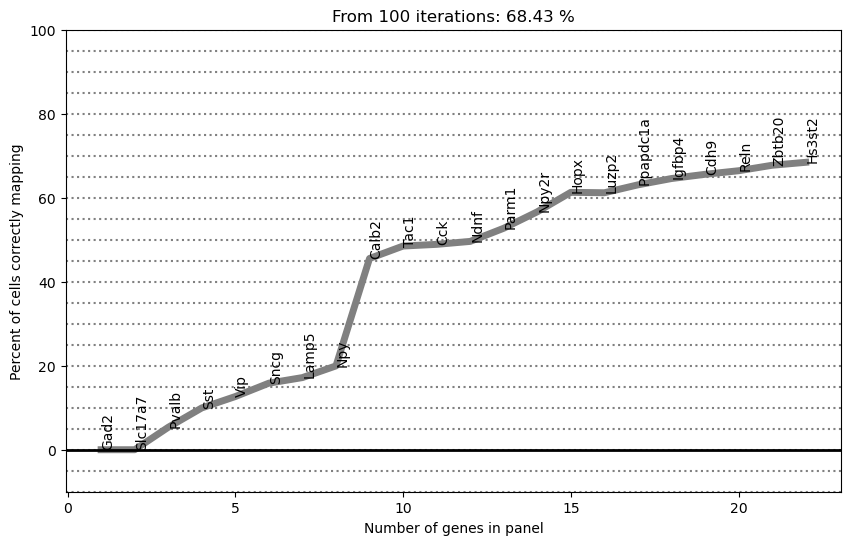

In [28]:
keep_sampled_cells = annotation.query('mapping_label in @keep_mappings').index.values
fig, ax = plt.subplots(figsize=(10,6))
frac, ax = plotting.fraction_correct_with_genes(built_panel, 
                map_data=tpm_log2.loc[run_genes, keep_sampled_cells].copy(),
                median_data=tpm_median_per_mapping.loc[run_genes, keep_mappings].copy(),
                cluster_call=annotation.loc[keep_sampled_cells, 'mapping_label'].copy(),
                ax=ax)
ax.set_title(f'From 100 iterations: {frac[-1]:.2f} %')

Text(0.5, 1.0, 'From no iteration: 55.54 %')

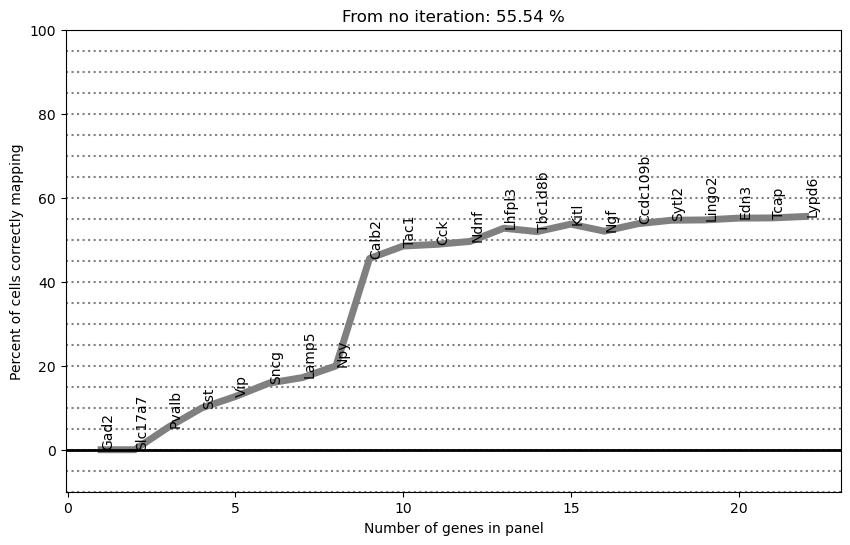

In [31]:
keep_sampled_cells = annotation.query('mapping_label in @keep_mappings').index.values
fig, ax = plt.subplots(figsize=(10,6))
frac_noiter, ax = plotting.fraction_correct_with_genes(built_panel_no_iter, 
                map_data=tpm_log2.loc[run_genes, keep_sampled_cells].copy(),
                median_data=tpm_median_per_mapping.loc[run_genes, keep_mappings].copy(),
                cluster_call=annotation.loc[keep_sampled_cells, 'mapping_label'].copy(),
                ax=ax)
ax.set_title(f'From no iteration: {frac_noiter[-1]:.2f} %')

# Plotting confusion matrices

In [34]:
corr_matrix_df = gene_panel_selection.cor_tree_mapping(
    map_data=tpm_log2.loc[:, keep_sampled_cells],
    median_data=tpm_median_per_mapping.loc[:, keep_mappings],
    genes_to_map=built_panel)
    
assigned_cluster = gene_panel_selection.get_top_match(corr_matrix_df)

confusion_matrix = plotting.get_confusion_matrix(
    annotation.loc[keep_sampled_cells, 'mapping_label'].values,
    assigned_cluster.top_leaf.values)


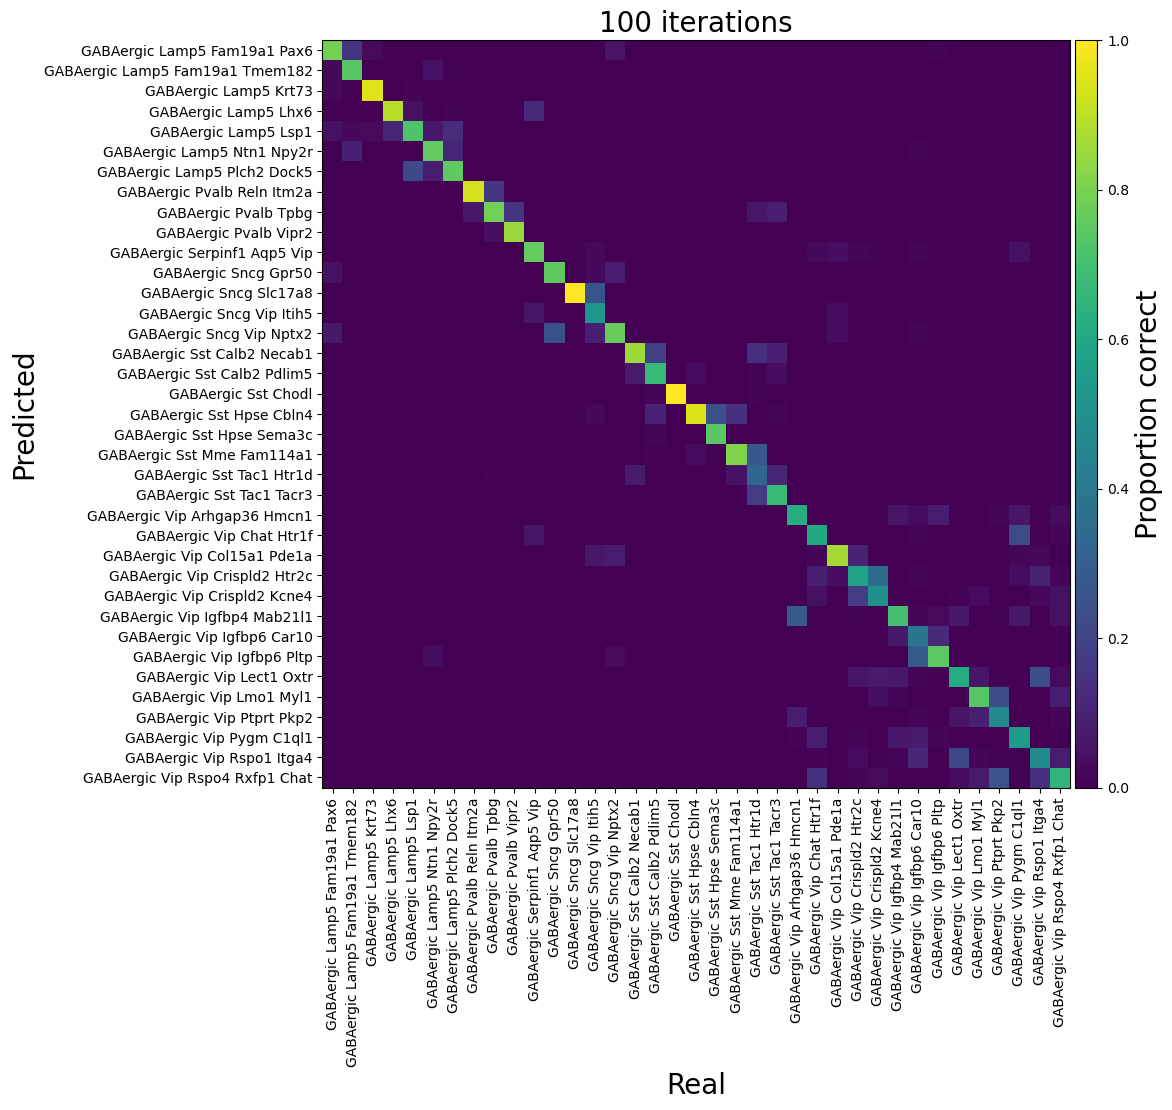

In [35]:
ax = plotting.plot_confusion_matrix(confusion_matrix, title_text='100 iterations')

In [36]:
corr_matrix_df_no_iter = gene_panel_selection.cor_tree_mapping(
    map_data=tpm_log2.loc[:, keep_sampled_cells],
    median_data=tpm_median_per_mapping.loc[:, keep_mappings],
    genes_to_map=built_panel_no_iter)
    
assigned_cluster_no_iter = gene_panel_selection.get_top_match(corr_matrix_df_no_iter)

confusion_matrix_no_iter = plotting.get_confusion_matrix(
    annotation.loc[keep_sampled_cells, 'mapping_label'].values,
    assigned_cluster_no_iter.top_leaf.values)

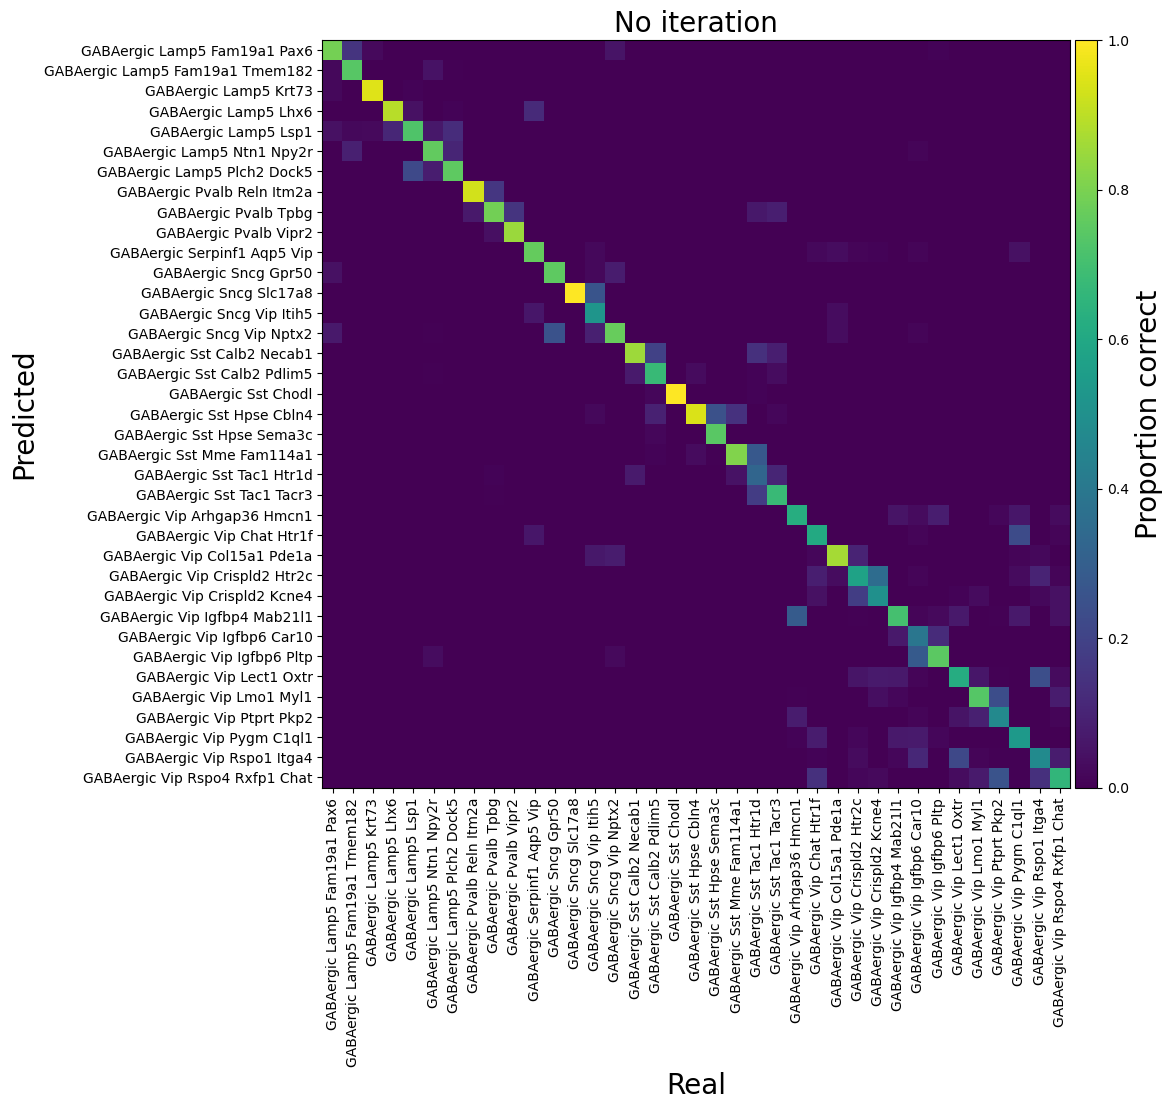

In [37]:
ax = plotting.plot_confusion_matrix(confusion_matrix, title_text='No iteration')

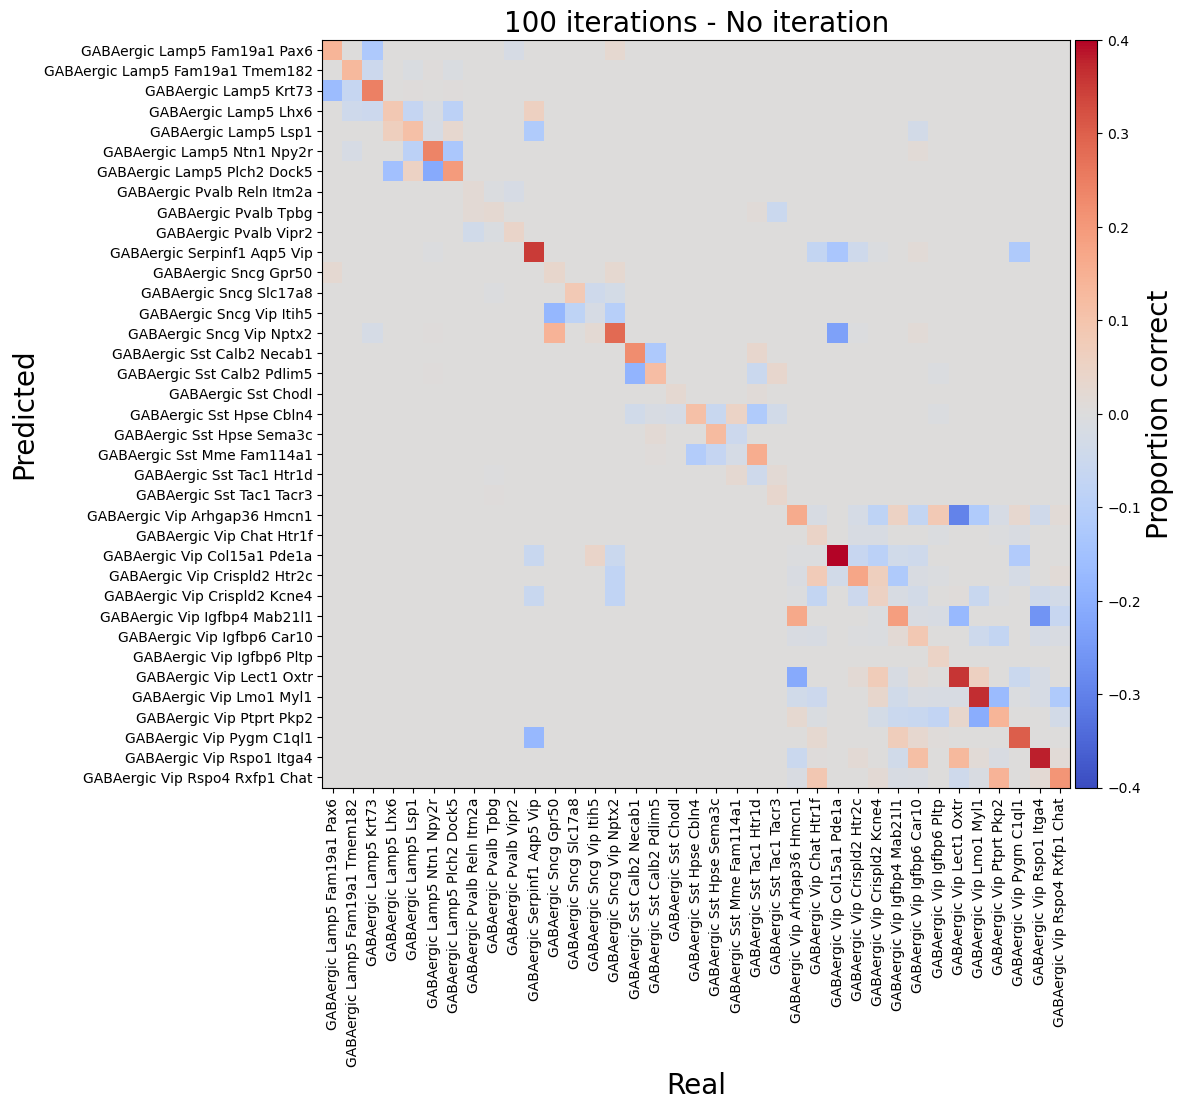

In [39]:
ax = plotting.plot_confusion_matrix_diff(confusion_matrix - confusion_matrix_no_iter, title_text='100 iterations - No iteration',
                                         cmap='coolwarm')